In [33]:
import yfinance as yf
import numpy as np
import pandas as pd
import arch
import matplotlib.pyplot as plt

In [34]:
ticker = "^GSPC"
data = yf.download(ticker, start="1962-01-02", end="2023-01-01")

C:\Users\jdobe\AppData\Local\Temp\ipykernel_5512\2274404261.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="1962-01-02", end="2023-01-01")
[*********************100%***********************]  1 of 1 completed


In [35]:
print(data.head())
print(data.shape)

Price           Close       High        Low       Open   Volume
Ticker          ^GSPC      ^GSPC      ^GSPC      ^GSPC    ^GSPC
Date                                                           
1962-01-02  70.959999  71.959999  70.709999  71.550003  3120000
1962-01-03  71.129997  71.480003  70.379997  70.959999  3590000
1962-01-04  70.639999  71.620003  70.449997  71.129997  4450000
1962-01-05  69.660004  70.839996  69.349998  70.639999  4630000
1962-01-08  69.120003  69.839996  68.169998  69.660004  4620000
(15356, 5)


In [36]:
# Create variable Log Returns and further
data["DailyReturn"] = np.log(data["Close"]).diff()
data['Sign_1d'] = (data['DailyReturn'] > 0).astype(int)
data['Volume_change'] = np.log(data['Volume']).diff()
data['Trading_range'] = np.log(data['High'] / data['Low'])

data = data.iloc[1:]

In [37]:
model = arch.arch_model(data["DailyReturn"]*1000, vol="GARCH", p=1, q=1)
model_fit = model.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 780727851372.1755
Iteration:      2,   Func. Count:     14,   Neg. LLF: 18031389.150344383
Iteration:      3,   Func. Count:     21,   Neg. LLF: 54663.01721751453
Iteration:      4,   Func. Count:     27,   Neg. LLF: 54549.42168044949
Iteration:      5,   Func. Count:     33,   Neg. LLF: 56596.042303034905
Iteration:      6,   Func. Count:     39,   Neg. LLF: 54588.092763351
Iteration:      7,   Func. Count:     45,   Neg. LLF: 54518.354737768575
Iteration:      8,   Func. Count:     51,   Neg. LLF: 54565.79750354307
Iteration:      9,   Func. Count:     57,   Neg. LLF: 54511.77134661394
Iteration:     10,   Func. Count:     62,   Neg. LLF: 54511.761345715364
Iteration:     11,   Func. Count:     67,   Neg. LLF: 54511.76129966311
Iteration:     12,   Func. Count:     72,   Neg. LLF: 54511.7612991028
Optimization terminated successfully    (Exit mode 0)
            Current function value: 54511.7612991028
            Iterations: 12
 

# Deep Learning

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import random
from sklearn.preprocessing import StandardScaler

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [39]:
NUMBER_OF_LAGS = 20  # number of lagged observations
TRAIN_SIZE = 5000
HIDDEN_DIM = 16
NUM_LAYERS = 1
DROPOUT = 0.0
BATCH_SIZE = 5000
NUMBER_OF_EPOCHS = 50
CLASSIFICATION_THRESHOLD = 0.5

TODO: Add more variables

10 Year US Treasury Bills (Ticker: ^TNX)

In [40]:
ten_y_tbill = yf.download("^TNX", start="1962-01-02", end="2023-01-01")
three_month_tbill = yf.download("^IRX", start="1962-01-02", end="2023-01-01")
# merge Close price of interest rates with main data
data = data.merge(ten_y_tbill[["Close"]], left_index=True, right_index=True, how="left", suffixes=('', '_TNX'))
data = data.merge(three_month_tbill[["Close"]], left_index=True, right_index=True, how="left", suffixes=('', '_IRX'))

# Drop MultiIndex in columns
data.columns = ['_'.join([str(level) for level in col if level]).replace('^', '') for col in data.columns]
data = data.rename(columns={
    ('Close_TNX'): ('ten_y_tnotes'),   # or any new tuple you want
    ('Close_IRX'): ('three_months_tbills')
})

C:\Users\jdobe\AppData\Local\Temp\ipykernel_5512\577084386.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  ten_y_tbill = yf.download("^TNX", start="1962-01-02", end="2023-01-01")
[*********************100%***********************]  1 of 1 completed
C:\Users\jdobe\AppData\Local\Temp\ipykernel_5512\577084386.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  three_month_tbill = yf.download("^IRX", start="1962-01-02", end="2023-01-01")
[*********************100%***********************]  1 of 1 completed


In [41]:
# Add lagged returns as features
data['Return_Lag1'] = data['DailyReturn'].shift(1)
data['GARCH_volatility'] = model_fit.conditional_volatility

data = data.dropna()

# Feature matrix: inv_vol + lagged returns
features = np.column_stack([
    data['GARCH_volatility'].values,
    data['Return_Lag1'].values,
    data['Volume_change'].values,
    data['Trading_range'].values,
    data['ten_y_tnotes'].values,
    data['three_months_tbills'].values
])

input_variables = features.shape[1]

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [42]:
data.to_csv("sp500_data_with_features.csv")

Currently, the past returns and inverse volatility are used for predicting the next return. This might not be economically sensible as many people believe returns are independent and form a martingale difference sequence (MDS). 

In [43]:
features

array([[ 5.68052228e+00,  2.39282503e-03,  2.14751894e-01,
         1.64712079e-02,  3.99000001e+00,  2.72000003e+00],
       [ 5.93868951e+00, -6.91260248e-03,  3.96527719e-02,
         2.12576365e-02,  4.01999998e+00,  2.74000001e+00],
       [ 7.27679593e+00, -1.39702301e-02, -2.16216300e-03,
         2.42023006e-02,  4.03000021e+00,  2.77999997e+00],
       ...,
       [ 1.20964653e+01, -4.05784403e-03,  1.74101770e-02,
         1.77063619e-02,  3.88700008e+00,  4.33799982e+00],
       [ 1.21473612e+01, -1.20934704e-02, -2.62335980e-02,
         1.37639095e-02,  3.83500004e+00,  4.29500008e+00],
       [ 1.26780394e+01,  1.73106343e-02, -7.95852819e-03,
         1.03427692e-02,  3.87899995e+00,  4.26000023e+00]],
      shape=(15233, 6))

By using StandardScaler, each variable will be standard normally distributed.

In [44]:
# Create lagged feature matrix for LSTM
def create_lagged_matrix_multifeature(X, window):
    out = []
    for i in range(window, len(X)):
        out.append(X[i-window:i, :])
    return np.array(out)

X_lagged = create_lagged_matrix_multifeature(features, NUMBER_OF_LAGS)
y_target = data['Sign_1d'].values[NUMBER_OF_LAGS:]

In [45]:
# Split train/test
X_train = X_lagged[:TRAIN_SIZE]
y_train = y_target[:TRAIN_SIZE]
X_test = X_lagged[TRAIN_SIZE:]
y_test = y_target[TRAIN_SIZE:]

# Convert to torch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)

## Define LSTM Model

In [46]:
class SimpleLSTM(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=16, num_layers=1, dropout=0.0):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.0)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return self.sigmoid(out)

model = SimpleLSTM(input_dim=input_variables, hidden_dim=HIDDEN_DIM, num_layers=NUM_LAYERS, dropout=DROPOUT)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCELoss()

In [47]:
model

SimpleLSTM(
  (lstm): LSTM(6, 16, batch_first=True)
  (fc): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

## Model Training

X_train_t contains batch size, sequence length (number of lags) and number of variables.
Pytorch automatically calls forward()-method when input is given to the model.

In [48]:
train_dataset = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

model.train()
for epoch in range(NUMBER_OF_EPOCHS):     # number of seeing the training data for learning parameters
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: loss = {loss.item():.4f}")

Epoch 0: loss = 0.6940
Epoch 10: loss = 0.6918
Epoch 20: loss = 0.6911
Epoch 30: loss = 0.6898
Epoch 40: loss = 0.6892


### Out of sample Prediction

In [49]:
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_t).squeeze().numpy()
    y_pred_sign = (y_pred_test > CLASSIFICATION_THRESHOLD).astype(int)

# --- Results ---
results = pd.DataFrame({
    'Actual_Sign': y_test,
    'Predicted_Sign': y_pred_sign,
    'Probability': y_pred_test
}, index=data.index[NUMBER_OF_LAGS+TRAIN_SIZE:])

In [50]:
from sklearn.metrics import classification_report, accuracy_score

# Classification report
print("Classification Report:")
print(classification_report(results['Actual_Sign'], results['Predicted_Sign']))
print("Accuracy:", accuracy_score(results['Actual_Sign'], results['Predicted_Sign']))

Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.26      0.34      4762
           1       0.54      0.75      0.62      5451

    accuracy                           0.52     10213
   macro avg       0.50      0.50      0.48     10213
weighted avg       0.51      0.52      0.49     10213

Accuracy: 0.5195339273474983


Text(0.5, 1.0, 'Predicted Probability of Positive Return')

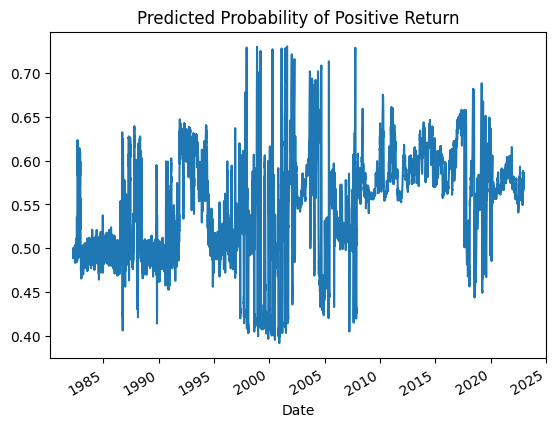

In [51]:
results["Probability"].plot()
plt.title("Predicted Probability of Positive Return")
#plt.ylim(0, 1)

In [52]:
results['GARCH_volatility'] = data['GARCH_volatility']
results['Daily_Return_S&P500'] = data['DailyReturn']
results['Close_S&P500'] = data['Close_GSPC']
results

,Actual_Sign,Predicted_Sign,Probability,GARCH_volatility,Daily_Return_S&P500,Close_S&P500
Date,,,,,,
1982-04-12,0,0,0.495733,8.281639,-0.001895,116.000000
1982-04-13,0,0,0.488419,7.939953,-0.000086,115.989998
1982-04-14,0,0,0.493605,7.586358,-0.001380,115.830002
1982-04-15,1,0,0.492227,7.276068,0.004479,116.349998
1982-04-16,1,0,0.494679,7.071575,0.003946,116.809998
...,...,...,...,...,...,...
2022-12-23,1,1,0.576629,13.196030,0.005851,3844.820068
2022-12-27,0,1,0.571894,12.644213,-0.004058,3829.250000
2022-12-28,0,1,0.578917,12.096465,-0.012093,3783.219971


## S&P500 forecasts

### Simple/Naive model
Use model of the form: (2*p - 1) * sigma * k where k is a calibration constant to scale returns

In [53]:
from sklearn.linear_model import LinearRegression

In [54]:
# estimate k
results['Signal'] = (2 * results['Probability'] - 1)
results['expected_signed_volatility'] = results['Signal'] * results['GARCH_volatility']

training_size = int(0.8 * len(results))

X = results[['expected_signed_volatility']]
y = results['Daily_Return_S&P500']

X_train = X[:training_size]
y_train = y[:training_size]
X_test = X[training_size:]
y_test = y[training_size:]

model = LinearRegression()
model.fit(X_train, y_train)
k = model.coef_[0]
print("Estimated k:", k)

Estimated k: 4.89484636570874e-05


In [55]:
full_results = results.copy()
results = results.iloc[training_size:]
return_hat = results['expected_signed_volatility'] * k
results['Return_Hat'] = return_hat
results["predicted Close"] = np.exp(np.log(results['Close_S&P500'].shift(1)) + results['Return_Hat'])
results

C:\Users\jdobe\AppData\Local\Temp\ipykernel_5512\2909796926.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['Return_Hat'] = return_hat
C:\Users\jdobe\AppData\Local\Temp\ipykernel_5512\2909796926.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["predicted Close"] = np.exp(np.log(results['Close_S&P500'].shift(1)) + results['Return_Hat'])


,Actual_Sign,Predicted_Sign,Probability,GARCH_volatility,Daily_Return_S&P500,Close_S&P500,Signal,expected_signed_volatility,Return_Hat,predicted Close
Date,,,,,,,,,,
2014-11-18,1,1,0.607615,6.295260,0.005121,2051.800049,0.215231,1.354933,0.000066,NaN
2014-11-19,0,1,0.609773,6.213957,-0.001502,2048.719971,0.219545,1.364246,0.000067,2051.937068
2014-11-20,1,1,0.612997,6.000979,0.001965,2052.750000,0.225995,1.356191,0.000066,2048.855976
2014-11-21,1,1,0.616881,5.788090,0.005223,2063.500000,0.233763,1.353040,0.000066,2052.885957
2014-11-24,1,1,0.615046,5.763117,0.002860,2069.409912,0.230093,1.326051,0.000065,2063.633942
...,...,...,...,...,...,...,...,...,...,...
2022-12-23,1,1,0.576629,13.196030,0.005851,3844.820068,0.153258,2.022403,0.000099,3822.768303
2022-12-27,0,1,0.571894,12.644213,-0.004058,3829.250000,0.143788,1.818089,0.000089,3845.162244
2022-12-28,0,1,0.578917,12.096465,-0.012093,3783.219971,0.157834,1.909236,0.000093,3829.607876


In [56]:
# evaluate predicted return vs actual return
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(results['Daily_Return_S&P500'], results['Return_Hat'])
print("Mean Squared Error of Return Prediction:", mse)

Mean Squared Error of Return Prediction: 0.00014119079636823486


In [57]:
# evaluated predicted price vs actual price
results = results.dropna()
mse_price = mean_squared_error(results['Close_S&P500'], results['predicted Close'])
print("Mean Squared Error of Price Prediction:", mse_price)

Mean Squared Error of Price Prediction: 1343.6648706693213


### Sophisticated Approach: Another NN for Return Prediction

In [58]:
y = full_results["Daily_Return_S&P500"]
X = full_results[["Probability", "GARCH_volatility"]]

In [59]:
# Training and test set split
training_size = int(0.8 * len(full_results))
X_train = X[:training_size]
y_train = y[:training_size]
X_test = X[training_size:]
y_test = y[training_size:]

# transform to tensors
X_train_t = torch.tensor(X_train.values, dtype=torch.float32).unsqueeze(1)
y_train_t = torch.tensor(y_train.values.reshape(-1, 1), dtype=torch.float32)
X_test_t = torch.tensor(X_test.values, dtype=torch.float32).unsqueeze(1)        

In [60]:
class ReturnGRU(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=16, num_layers=1, dropout=0.0):
        super(ReturnGRU, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

hidden_dim = 16
num_layers = 1
dropout = 0.0

model = ReturnGRU(input_dim=X.shape[1], hidden_dim=hidden_dim, num_layers=num_layers, dropout=dropout)
optimizer = optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.MSELoss()
batch_size = 32
num_epochs = 30
train_dataset = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


In [61]:
model.train()
for epoch in range(num_epochs+1):
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: loss = {loss.item():.6f}")


Epoch 0: loss = 0.000168
Epoch 10: loss = 0.000047
Epoch 20: loss = 0.000016
Epoch 30: loss = 0.000043


In [62]:
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_t).squeeze().numpy()
return_results = pd.DataFrame({
    'Actual_Return': y_test,
    'Predicted_Return': y_pred_test
})

mse = mean_squared_error(return_results['Actual_Return'], return_results['Predicted_Return'])
print("Mean Squared Error of Return Prediction (GRU):", mse)


Mean Squared Error of Return Prediction (GRU): 0.00014141076663023593


In [63]:
return_results['Close_S&P500'] = full_results['Close_S&P500'].iloc[training_size:].values
return_results["Predicted_Close"] = np.exp(np.log(return_results['Close_S&P500'].shift(1)) + return_results['Predicted_Return'])
return_results 

,Actual_Return,Predicted_Return,Close_S&P500,Predicted_Close
Date,,,,
2014-11-18,0.005121,-0.000103,2051.800049,NaN
2014-11-19,-0.001502,-0.000094,2048.719971,2051.607074
2014-11-20,0.001965,-0.000083,2052.750000,2048.550660
2014-11-21,0.005223,-0.000075,2063.500000,2052.595963
2014-11-24,0.002860,-0.000084,2069.409912,2063.326855
...,...,...,...,...
2022-12-23,0.005851,0.000327,3844.820068,3823.639714
2022-12-27,-0.004058,0.000233,3829.250000,3845.715493
2022-12-28,-0.012093,0.000140,3783.219971,3829.787902


In [64]:
return_results.dropna(inplace=True)
mse_price = mean_squared_error(return_results['Close_S&P500'], return_results['Predicted_Close'])
print("Mean Squared Error of Price Prediction (GRU):", mse_price)

Mean Squared Error of Price Prediction (GRU): 1346.5344010912138
